---
# <div align="center"><font color='green'> COSC 2673/2793 |  Machine Learning | Assignment 2 </font></div>
## <div align="center"> <font color='black'> Student Name: Chee Kin Go, Vincent Bethlehem </font></div>
## <div align="center"> <font color='red'> Student number: s3955624, s3899816 </font></div>
---

In [1]:
# To ensure Jupyter Notebook width size is same as your device viewport
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Problem statement

As a team of machine learning engineers at a biomedical startup, the goal is to build two separate classification model in analyzing histopathology images of colon cells:
- isCancerous Classification: Binary classification to determine whether a cell image represents cancerous cells
- Cell-Type Classification: Multi-class classification to identify cell types (fibroblast, inflammatory, epithelial, or others)

Various classification models are implemented and evaluated:
- isCancerous Classification:
    - Baseline:
    - Advanced:

- Cell-Type Classification:
     - Baseline:
     - Advanced:

By the end of evaluation, We aim to select the best-performing model for each classification method with justification

## Exploratory Data Analysis (EDA)

Top 5 rows:
   InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0       22405          1  22405.png   fibroblast         0            0
1       22406          1  22406.png   fibroblast         0            0
2       22407          1  22407.png   fibroblast         0            0
3       22408          1  22408.png   fibroblast         0            0
4       22409          1  22409.png   fibroblast         0            0

Bottom 5 rows:
      InstanceID  patientID ImageName cellTypeName  cellType  isCancerous
9891        1625         60  1625.png   epithelial         2            1
9892        1626         60  1626.png   epithelial         2            1
9893        1627         60  1627.png   epithelial         2            1
9894        1628         60  1628.png   epithelial         2            1
9895        1629         60  1629.png   epithelial         2            1

Dataframe dimension:
(9896, 6)

Dataframe summary:
<class 'pandas.core.frame.DataFrame'>
RangeI

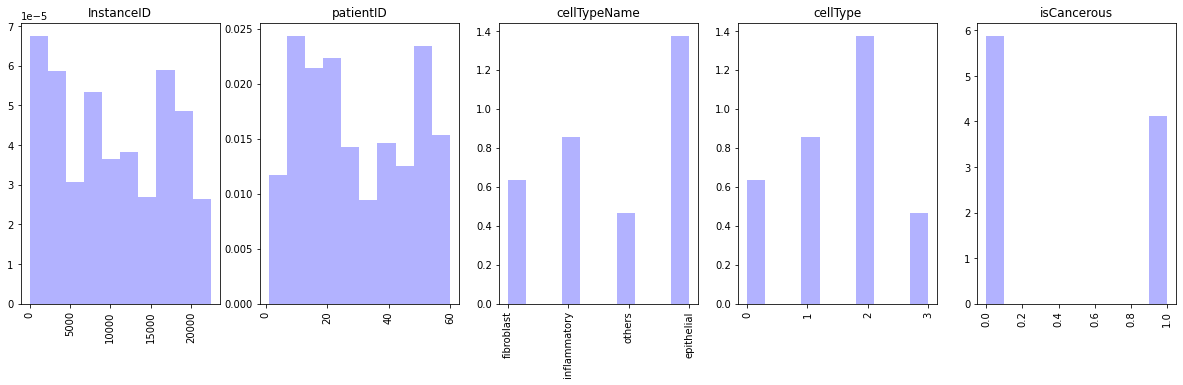


Correlation Matrix between variables:


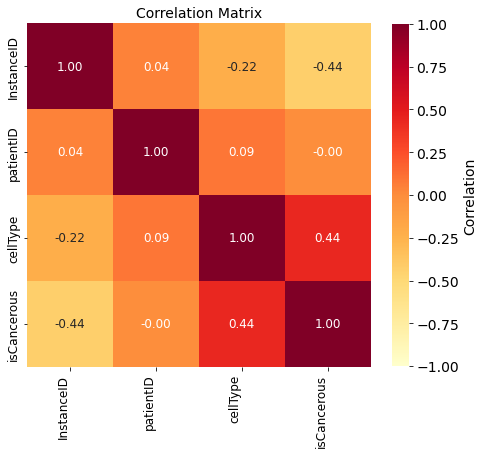

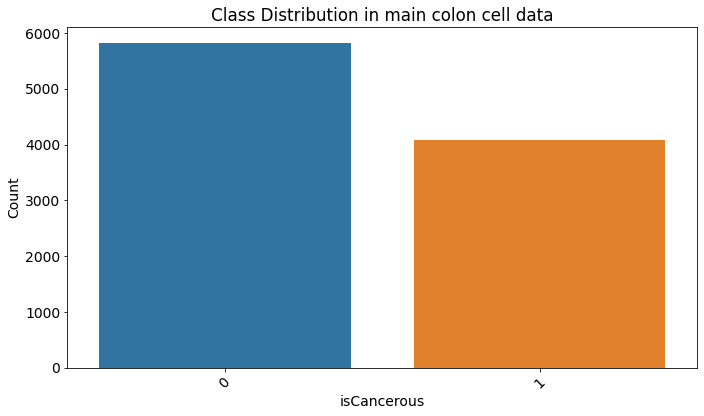


Relationship between isCancerous and other variables:


<Figure size 2160x3600 with 0 Axes>

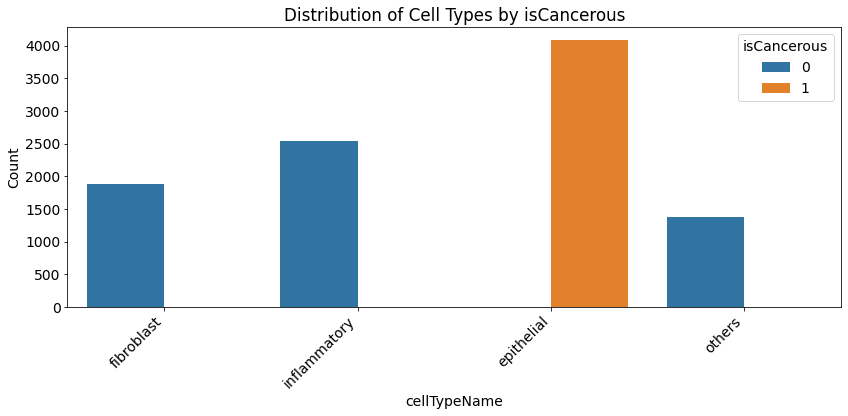

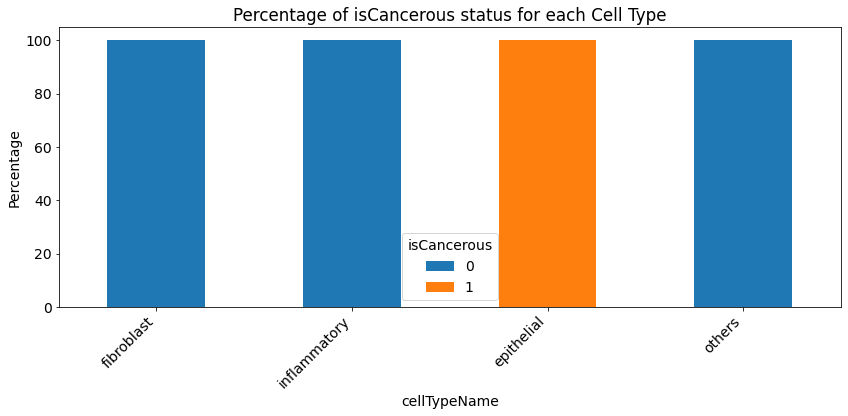


Scatter plot between InstanceID and isCancerous for each Cell Type:


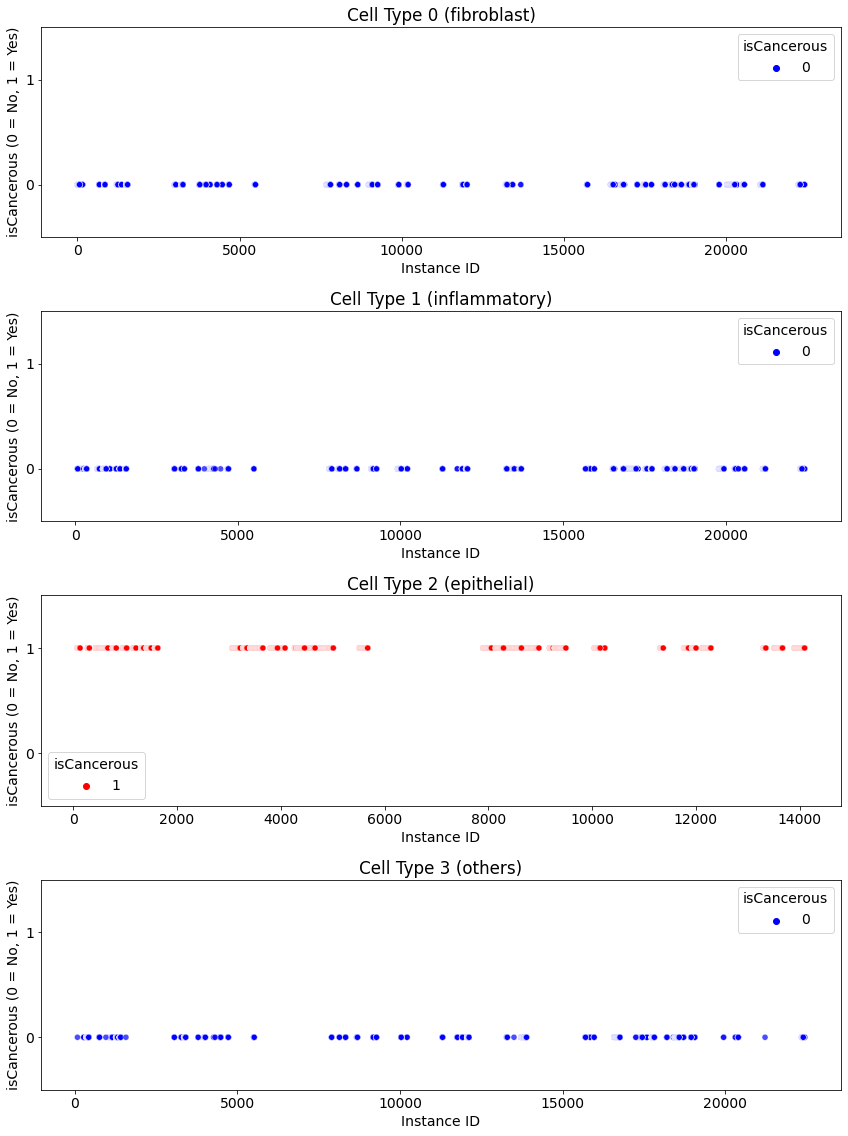


Pairplot matrix between all variables with isCancerous hue:


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import os

# Set display options to show all columns
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Unlimited width
pd.set_option('display.expand_frame_repr', False)  # Don't wrap to multiple lines

# read csv file
mainColonCellFrame = pd.read_csv('data_labels_mainData.csv', delimiter=',')

# Print top 5 rows
print("Top 5 rows:")
print(mainColonCellFrame.head())

# Print bottom 5 rows
print("\nBottom 5 rows:")
print(mainColonCellFrame.tail())

# display dataframe dimension
print("\nDataframe dimension:")
print(mainColonCellFrame.shape)

# display dataframe summary
print("\nDataframe summary:")
print(mainColonCellFrame.info())

# check for missing value
print("\nMissing values:")
print(pd.isna(mainColonCellFrame).sum())

# Check unique values for all columns
for column in mainColonCellFrame.columns:
    print(f"\nUnique values for {column}:")
    if mainColonCellFrame[column].nunique() > 10:
        print(f"Total unique values: {mainColonCellFrame[column].nunique()}")
        print("Sample of values (first 10):")
        print(mainColonCellFrame[column].value_counts().head(10))
    else:
        print(mainColonCellFrame[column].value_counts())
    print("-" * 50)

# display dataframe statistics
print("\nDataframe statistics:")
print(mainColonCellFrame.describe())

#Distirbution for each variable
print("\nDistribution for each variable:")
plt.figure(figsize=(25,30))
#didnt do image name because its not relevant
for i, col in enumerate([c for c in mainColonCellFrame.columns if c != 'ImageName']):
    plt.subplot(5, 6, i + 1)
    plt.hist(mainColonCellFrame[col], alpha=0.3, color='b', density=True)
    plt.title(col)
    plt.xticks(rotation='vertical')
plt.show()
    
# Correlation Matrix between variables
print("\nCorrelation Matrix between variables:")
f, ax = plt.subplots(figsize=(7, 7))
corr = mainColonCellFrame.corr()

# Increase font sizes
plt.rcParams.update({'font.size': 14})  # Base font size
cbar_kws = {"shrink": 0.8, "label": "Correlation"}

# Create the heatmap with annotations and a famous color palette
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap="YlOrRd",  # Use the yellow-orange-red palette
    square=True,
    annot=True,  # This will print the values on the heatmap
    fmt=".2f",   # Format the annotations to 2 decimal places
    annot_kws={"size": 12}, 
    cbar_kws=cbar_kws
)

# Rotate x-axis labels for better readability
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right',
    fontsize=12
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize=12 
)

# Increase title font size
plt.title("Correlation Matrix", fontsize=14)

# Show the plot
plt.tight_layout()  # Adjust layout to make room for bigger fonts
plt.show()

# class distribution
plt.figure(figsize=(10,6))
sns.countplot(data=mainColonCellFrame, x='isCancerous', order=mainColonCellFrame['isCancerous'].value_counts().index)
plt.title('Class Distribution in main colon cell data')
plt.xlabel('isCancerous')
plt.ylabel('Count')
plt.xticks(rotation=45)  # rotate if class names are long
plt.tight_layout()
plt.show()

# Relationship between isCancerous and other variables
print("\nRelationship between isCancerous and other variables:")
plt.figure(figsize=(30,50))

# Create a mapping from cellTypeName to cellType
cell_type_mapping = mainColonCellFrame[['cellTypeName', 'cellType']].drop_duplicates().set_index('cellTypeName')['cellType']

# Sort cell types by their numeric cellType value
ordered_cell_types = cell_type_mapping.sort_values().index.tolist()

# Count plot for Distribution of Cell Types by isCancerous with explicit order
plt.figure(figsize=(12, 6))
sns.countplot(data=mainColonCellFrame, x='cellTypeName', hue='isCancerous', order=ordered_cell_types)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Cell Types by isCancerous')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Stacked bar chart with the same order
bar_chart_iscancerous_by_cell_type = pd.crosstab(
    mainColonCellFrame['cellTypeName'], 
    mainColonCellFrame['isCancerous'], 
    normalize='index'
).mul(100)

# Reindex the DataFrame to match the order based on cellType numeric value
bar_chart_iscancerous_by_cell_type = bar_chart_iscancerous_by_cell_type.reindex(ordered_cell_types)

bar_chart_iscancerous_by_cell_type.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xticks(rotation=45, ha='right')
plt.title('Percentage of isCancerous status for each Cell Type')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

# Scatter plot between each cell type, PatientID and isCancerous
# Get unique cell types
mainColonCellFrame_unique_cell_types = mainColonCellFrame['cellType'].unique()

# Create a subplot for each cell type
fig, axes = plt.subplots(len(mainColonCellFrame_unique_cell_types), 1, figsize=(12, 4*len(mainColonCellFrame_unique_cell_types)))

# If there's only one cell type, axes won't be an array, so convert it to one
if len(mainColonCellFrame_unique_cell_types) == 1:
    axes = [axes]

# Create a scatter plot for each cell type
print("\nScatter plot between InstanceID and isCancerous for each Cell Type:")
for i, cell_type in enumerate(sorted(mainColonCellFrame_unique_cell_types)):
    # Filter data for current cell type
    cell_data = mainColonCellFrame[mainColonCellFrame['cellType'] == cell_type]
    
    # Get the cell type name for the title
    cell_type_name = cell_data['cellTypeName'].iloc[0] if not cell_data.empty else f"Type {cell_type}"
    
    
    # Create scatter plot
    sns.scatterplot(
        data=cell_data, 
        x='InstanceID', 
        y='isCancerous',
        hue='isCancerous', 
        palette={0: 'blue', 1: 'red'}, 
        alpha=0.7,
        ax=axes[i]
    )
    
    # Set title and labels
    axes[i].set_title(f'Cell Type {cell_type} ({cell_type_name})')
    axes[i].set_xlabel('Instance ID')
    axes[i].set_ylabel('isCancerous (0 = No, 1 = Yes)')
    
    # Set y-axis to show only 0 and 1
    axes[i].set_yticks([0, 1])
    axes[i].set_ylim(-0.5, 1.5)
    
plt.tight_layout()
plt.show()

# Create a Pair plot for each variable with target variable hue (isCancerous)
print("\nPairplot matrix between all variables with isCancerous hue:")
isCancerous_pair_plot = sns.PairGrid(
    mainColonCellFrame, 
    vars=['InstanceID', 'patientID', 'cellTypeName', 'cellType'], 
    hue="isCancerous",
    palette={0: 'blue', 1: 'orange'}
)
isCancerous_pair_plot.map(sns.scatterplot)

# Remove auto-generated legends
for ax in isCancerous_pair_plot.axes.flat:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

# Add legend
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10)
]
isCancerous_pair_plot.fig.legend(
    custom_lines, 
    ["Non-Cancerous", "Cancerous"], 
    title="isCancerous",
    loc='center right',
    bbox_to_anchor=(1.25, 0.5)
)

plt.tight_layout()
plt.show()

# Create a Pair plot for each variable with target variable hue (cellType)
print("\nPairplot matrix between all variables with cellType hue:")
cellType_pair_plot = sns.PairGrid(mainColonCellFrame, vars=['InstanceID','patientID', 'isCancerous', 'cellTypeName'], hue="cellType")
cellType_pair_plot.map(sns.scatterplot)

# Get unique cell type names for the legend
cell_type_labels = {
    cell_type: name 
    for cell_type, name in zip(
        mainColonCellFrame['cellType'].unique(),
        mainColonCellFrame.drop_duplicates(subset=['cellType'])['cellTypeName']
    )
}
# Sort by cell type value
sorted_labels = [cell_type_labels[i] for i in sorted(cell_type_labels.keys())]

cellType_pair_plot.add_legend(title="Cell Type", labels=sorted_labels)
plt.show()



print("\nSample image for each cell type:")
# unique cell type labels
mainColonCellFrame_cell_types = mainColonCellFrame['cellTypeName'].unique()
example_images = {}

# Choose random image
for cell in mainColonCellFrame_cell_types:
    one_row = mainColonCellFrame[mainColonCellFrame['cellTypeName'] == cell].sample(1)
    example_images[cell] = one_row['ImageName'].values[0]

# grid
fig, axes = plt.subplots(1, len(mainColonCellFrame_cell_types), figsize=(len(mainColonCellFrame_cell_types) * 5, 5))

# Loop selected image + display
for ax, (cell, filename) in zip(axes, example_images.items()):
    path = os.path.join("patch_images", filename)
    img = mpimg.imread(path)
    ax.imshow(img)
    ax.set_title(cell)
    ax.axis('off')

plt.tight_layout()
plt.show()

### EDA result Analysis and deriven conclusion

Exploratory Data Analysis is the essential first step in the machine learning project which we perform initial investigations on data to:
 - Develop a comprehensive understanding of training dataset;
 - Reveal hidden patterns and feature relationship;
 - Identify most predictive variables;
 - Spot outliers that might skew model performance;
 - Test and validate assumptions required by various algorithms
 - Build parsimonious models (simplest model that is "reasonably" consistent with the experience); and
 - Determine the optimal hyperparameter starting points.
 
This investigative process helps to better understand the colon cell data before building models, potentially saving significant time and improving results by identifying issues early in the development cycle.

#### Data Loading
To ensure the data is loaded correctly, we print the top and bottom 5 rows to the dataset

The data is loaded into a data frame and printed it out. The abbreviated column names:
- **InstanceID**: Unique identifier for each individual cell instance
- **patientID**: Unique identifier for each patient. Multiple cells may come from the same patient 
- **ImageName**: Filename of the image of the cell 
- **cellTypeName**: Descriptive name of the cell type (epithelial, lymphocyte, fibroblast and others) 
- **cellType**: Numeric code representing the cell type
- **isCancerous**: Binary indicator of Non-cancerous (0) and Cancerous (1) cell

<font color='green'> The target column is **isCancerous**.</font>
All the other columns are attributes.

The dataframe contains 9896 rows (9896 different cell instances collected), and 6 columns
- 3 columns has a int64 data type while other 2 columns has a object data type

#### No Missing Values
- No missing values found in the dataset

#### Dataframe Statistics
Classification of Variables in the Dataset as obtained from the statistical summary above:
- Categorical Variables
    - Nominal Categorical Variables: cellType, cellTypeName, isCancerous

- Numerical Variables
    - Discrete Numerical Variables: InstanceID, patientID

#### Historgram Plot for Distribution Pattern for all variables
Reason:
- visualise data distirbution - shape, spread and central tendency to see if its normal, multimodal, or skewed.
- check the mean, mode and median using the overall shape
- check for outlier if there is unusual frequency in the ranges

Observation from Histogram Plot:

# Vincent can fill here

#### Correlation Matrix between isCancerous and other variables
Reason:
- visualise how different variables relate with each other with its strength and direction (positive/negative)
- to spot multicollinearity by identifying extremely high correlations between predictors

Observations:
- Strong Predictors (|r| > 0.5):
    - None

- Moderate Predictors (0.3 < |r| < 0.5):
    - cellType: (0.44) (positive correlation)
    - instanceID: (-0.44) (negative correlation)

- Weak Predictors (|r| < 0.3):
    - patientID: (0.00) (no correlation)

<font color='red'>We can conclude that there is no presence of multicollinearity in the dataset</font>

#### isCancerous Class Distribution Plot
Reason:
- identify whether the dataset is balanced or imbalanced
- determine whether data resampling, or data augmentation is needed to address biases

Observations:
- Moderate level of class imblance present with approx 5800 non-cancerous instances, and approx 4,100 cancerous instances (ratio is 58:42)
- cancerous instance has a considerable portion in dataset, so classification methods can still work well with carefully selected evalutaiton metrics

#### Bar Chart for Distirbution for each Cell Type by isCancerous
Reason:
- Visualise which cell types are associated with cancerous status to be identified as potential predictive indicators which helps understand biological aspects of classification problem.

Observations:
- Cancer is only labeled in epithelial cells because all cancerous cells (100%) only present in epithelial cells (approx 4000 instances). 
- Non-cancerous cells are distributed among fibroblast (approx 1900), inflammatory (approx 2500) and "others" cells (approx 1400). No epithelial cells are labeled as non-cancerous.

#### Bar Chart for Percentage of isCancerous status for each Cell Type
Reason:
- Show the proportion of the isCancerous status distribution for each cell type regardless of its absolute counts

Observations:
- Confirms that 100% of epithelial cell are cancerous, and 100% of other cells are non-cancerous.
- Represents that there's a strong predictive relationship between cell type and isCancerous where identifying whether a cell is epithelial or not is enough to determine its cancerous status. Cell type could be used as criteria for classfication model.

#### Scatter plot between InstanceID and isCancerous for each Cell Type
Reason:
- Idenitfy pattern between distribution of instance identificatioin and isCancerous status for each cell type

Observations:
- Confirm previous obvservation where only epithelial cells are cancerous while others are non-cancerous
- Support previous asumption where there is predictive relationship between cell type and cancer status
- For non-epithelial cells, instanceID ranges from 0 to above 20000, while epithelial cells only until 14000. This suggests epithelial cells were collected differently or earlier during sample collection. 
- Clustering of instanceID present across all cell types, suggest batch collection of sample collection. Cluster are seen in 0 to 20000, 5000, 10000, and between 15000 to 20000

#### Pairplot matrix between all variables with isCancerous hue:
Reason:
- visualise relationships between multiple variables simultaneously with cancer status as hue. Allow pattern to be identified that is not viewable in bivariate plots.
- check if non-linear or linear boundary can separate the two isCancerous classes

Observations:
- in patientID vs instanceID, and plots invloving cellType and cellTypeName, linear decision boundary can clearly separate the two classes
- None of the plot suggest non-linear decision boundary for class separation
- isCancerous clustering present in patientID where certain pateint has more cancerous samples, while other have more non-cancerous samples. This suggest there's biasness in patient selection when creating dataset.
- CellTypeName and CellType are highly correlated. cell type 2 corresponds to epithelial, while 0, 1, and 3 correspond to fibroblast, inflammatory, and other cells. This means feature removal can be performed as there is redundant feature.

# Vincent can fill here

#### Pairplot matrix between all variables with cellType hue:
Reason:
Observations:

#### Sample image for each cell type
Reason:
Observations:

## Data Splitting Strategy - train-validation-test splits

In [ ]:
# Data splitting - train-validation-test splits
print("\nData Splitting into Train, Validation and Test set:")
with pd.option_context('mode.chained_assignment', None):

# split data into 80% (training and validation) and 20% (test)
    train_data, test_data = train_test_split(mainColonCellFrame, test_size=0.2, shuffle=True, random_state=42)

#Split again for validation
    train_data, val_data = train_test_split(train_data, test_size=0.25, shuffle=True, random_state=42)

print(f"Training data: {len(train_data)}")
print(f"Validation data: {len(val_data)}")
print(f"Test data: {len(test_data)}")

print("\nClass Distribution for Train, Validation and Test set:")
# Set up figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Class distribution for Training Data
sns.countplot(data=train_data, x='isCancerous', order=train_data['isCancerous'].value_counts().index, ax=axes[0])
axes[0].set_title('Train Data')
axes[0].set_xlabel('isCancerous')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
 
# Class distribution for Validation Data
sns.countplot(data=val_data, x='isCancerous', order=train_data['isCancerous'].value_counts().index, ax=axes[1])
axes[1].set_title('Validation Data')
axes[1].set_xlabel('isCancerous')
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', rotation=45)
 
# Class distribution for Test Data
sns.countplot(data=test_data, x='isCancerous', order=train_data['isCancerous'].value_counts().index, ax=axes[2])
axes[2].set_title('Test Data')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('')
axes[2].tick_params(axis='x', rotation=45)
 
plt.tight_layout()
plt.show()

# Copy train, val, test data for each model

# -----isCancerous model-----
# baseline 
isCancerous_base_logisitic_regression_train_data = train_data.copy()
isCancerous_basee_logisitic_regression_val_data = val_data.copy()
isCancerous_basee_logisitic_regression_test_data = test_data.copy()

#### train-validation-test splits strategy
Reason:
- Ensure models are extremely reliable through using test set for unbiased measure of trained model's performance on unseen data.
- Validation set assists in parameter tunning on model to improce performance since there is imbalance between cancerous and non-cancerous cell distirbution. We can find a right balance between precision and recall using validation set while preserve data integrity
- Validation set assists in prevent overffiting when building complex multi-class classification model using cell types, which ensure model to be generalised well on unseen data 

#### Class Distribution for Train, Validation and Test set
Reason:
- Shows distribution of isCancerous cell in train, validation, and test sets to ensure the disitribution is maintained in all splits for non-bias model training and evaluation

Observations:
- All 3 sets maintain almost similar ratio of cancerous to non-cancerous cells. This is important to ensure model has the same class distribution during training, validation, and testing.
- Confirm 60/20/20 split is used with train set has approx 6000 cells, and both validation and test sets have approx 2000 cells each.

## Baseline development

### Performance Metrics Selection for all isCancerous Calssificiation Models

We use the following to evaluate all isCancerous models with justification:
- Macro Average Precision:
- Macro Average Recall
- Macro Average F1-score
- Confusion matirx
- ROC curve

- True Positive: actual Cancerous (1), predicted Cancerous (1)
- False Positive: actual non-Cancerous (0), predicted Cancerous (1)
- True Negative: actual non-Cancerous (0), predicted non-Cancerous (0)
- False Negative: actual Cancerous (1), predicted non-Cancerous (0) - This is a concern

    
These metrics allow us to conduct absolute and relative measures on model predictive performance. hence, we can have a comprehensive assessment on models.


### Logistic Regression Model for isCancerous

This task is belong to supervised binary classification.

No hyperparameter tunning is performed here.

<!-- 1. We train the multivariate linear regression model using ```X_train_capacity_baseline``` and ```y_train_capacity_baseline```, and then test the model on ```X_val_capacity_baseline``` for each fold

2. Next we evaluate each model using MSE and R² metrics

3. Then we averaged the MSE and R² metrics produced from each model. (we don't include model with negative R² value because the model performed very poorly)

4. We choose the model that has the closest MSE metrics values, and that its R² metrics values is not negative

5. We apply the chosen model on the test dataset ```X_test``` to obtain the prediction value

6. We evaluate the chosen model using MSE and R² metrics -->